In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter, fitness
from matplotlib import colors
from spatialentropy import leibovici_entropy, altieri_entropy
from datetime import date

In [145]:
sys.path.append("./utils")
from DoseResponseModel import DoseResponseModel

jarFileName = "./HAL_dose_response.jar"

consumpt_rate = [10**-4,0.001,0.01,0.1,0.5]

indx = 0
n_replicates = 1

# get today's date
today = date.today()

date_str = today.strftime("%Y-%m-%d")

data_folder = "./data/qs_analysis/" + date_str

for cr in consumpt_rate:
    modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':10000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":cr,
                    "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True}

    dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
    imgDir = "./data/doseResponseImages"

    myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
    myModel.Simulate()
    indx += 1

(<Figure size 1000x600 with 1 Axes>,
 <AxesSubplot:xlabel='Drug concentration ($\\mathrm{\\mu}$g/mL)', ylabel='Growth rate (hr$^{-1})$'>)

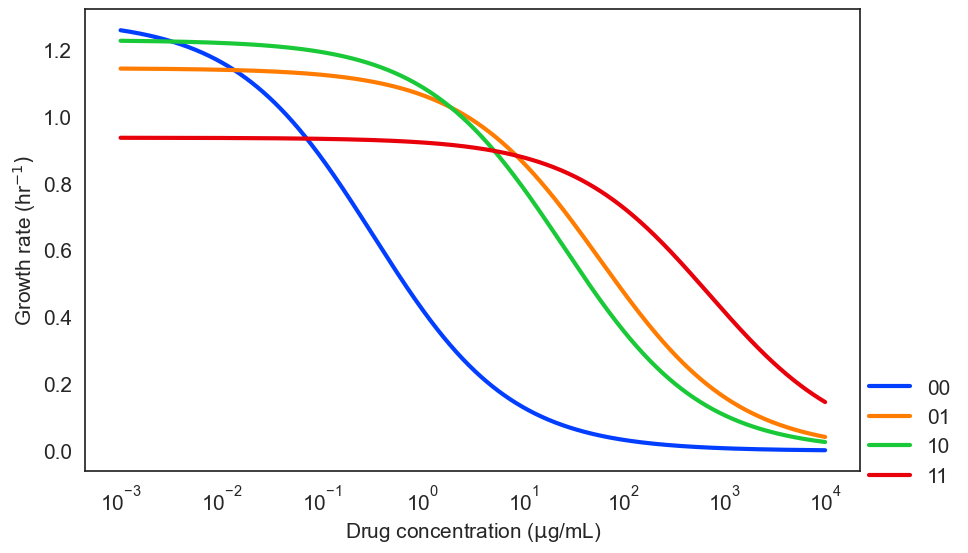

In [155]:
p = Population(death_model = None,n_allele=2,fitness_data='random')
p.drugless_rates = [1.28949852, 1.14399848, 1.22802236, 0.93619847]
p.ic50 = [-0.49205992, 1.76224515,  1.39341393,  2.84653598]
p.plot_fitness_curves()

In [147]:
def get_quasispecies_matrix(p,conc,mut_rate):
    """Returns a quasispecies matrix for a given concentration and mutation rate

    citation: Nowak MA. What is a quasispecies? Trends in Ecology & Evolution. 
            1992;7(4):118-121. doi:10.1016/0169-5347(92)90145-2

    Parameters
    ----------
    p : Population object
        Population object with fitness data
    conc : float
        Drug concentration
    mut_rate : float
        Mutation rate

    Returns
    -------
    numpy array

    """
    fit_land = p.gen_fit_land(conc)
    fit_mat = matlib.repmat(fit_land, p.n_genotype, 1)
    mut_map = p.random_mutations(p.n_genotype) + np.identity(p.n_genotype)
    mut_rate = np.ones((p.n_genotype,p.n_genotype))*mut_rate
    for i in range(p.n_genotype):
        mut_rate[i,i] = 1
        
    mut_map = np.multiply(mut_map,mut_rate)

    return np.multiply(fit_mat,mut_map)

def get_equilibrium_vect(p,conc,mut_rate):
    m = get_quasispecies_matrix(p,conc,mut_rate)
    e_val,e_vect = np.linalg.eig(m)
    e_vect = e_vect[:,np.argmax(e_val)]
    e_vect = e_vect/np.sum(e_vect)
    return e_vect



In [148]:
m = get_quasispecies_matrix(p,1,0.0001)

e_val,e_vect = np.linalg.eig(m)
indx = np.argwhere(e_val == np.max(e_val))[0][0]
print(m)
print("\n")
print(e_val)
print("\n")
dom_vect = e_vect[:,indx]
dom_vect = dom_vect/np.sum(dom_vect)
print(dom_vect*100)

print("\n")
print(get_equilibrium_vect(p,1,0.0001)*100)

[[4.21897291e-01 5.31786427e-05 5.43461499e-05 0.00000000e+00]
 [2.10948646e-05 1.06357285e+00 0.00000000e+00 4.60981499e-05]
 [2.10948646e-05 0.00000000e+00 1.08692300e+00 4.60981499e-05]
 [0.00000000e+00 5.31786427e-05 5.43461499e-05 9.21962998e-01]]


[0.42189729 1.08692301 1.06357287 0.92196297]


[8.16867841e-03 7.23934422e-05 9.99588274e+01 3.29315030e-02]


[8.16867841e-03 7.23934422e-05 9.99588274e+01 3.29315030e-02]


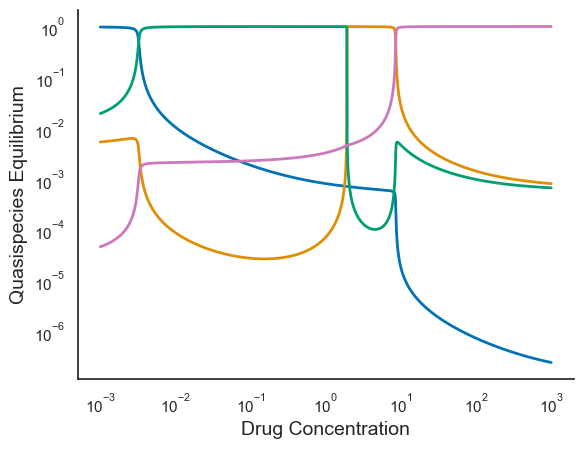

In [161]:
# plot quasispecies as a function of drug concentration
conc = np.logspace(-3,3,1000)
q_mat = np.zeros((p.n_genotype,len(conc)))

# mut_rates = np.logspace(-6,-1,6)
mut_rates = [0.001]
alpha_indx = 0
fig,ax = plt.subplots()
for mr in mut_rates:
    for i in range(len(conc)):
        eq = get_equilibrium_vect(p,conc[i],mr)
        q_mat[:,i] = eq
    cc = plotter.gen_color_cycler(style='solid',palette='colorblind',n_colors=p.n_genotype)
    ax.set_prop_cycle(cc)
    for i in range(p.n_genotype):
        alpha = 1/(1+alpha_indx/2)
        ax.plot(conc,q_mat[i,:],label = p.int_to_binary(i),linewidth=2,alpha=alpha)

    alpha_indx += 1

ax.set_xscale('log')
ax.set_yscale('log')
# ax.legend(frameon=False)
ax.set_xlabel('Drug Concentration',fontsize=14)
ax.set_ylabel('Quasispecies Equilibrium',fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [151]:
consumpt_rate = [10**-4,0.001,0.01,0.1,0.5]

diffGridList = []
img_t = np.zeros((100,100))
prop_est_list = []
prop_list = []

for i,rate in enumerate(consumpt_rate):
    # plot drug grid
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    dataFile = dataDir + '/RepId_0_diffGrid.csv'
    data = pd.read_csv(dataFile)
    for index,row in data.iterrows():
        if row['field'] > 0:
            img_t[int(row['x']),int(row['y'])] = row['field']
    diffGridList.append(img_t)

    prop_est = np.zeros((p.n_genotype))
    img_vect = img_t.flatten()
    dc_mean = np.mean(img_vect)
    for k in range(len(img_vect)):
        eq = get_equilibrium_vect(p,img_vect[k],0.0001)
        prop_est += eq
    prop_est = prop_est/np.sum(prop_est)
    prop_est_list.append(prop_est)

    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    
    prop_t = np.zeros((p.n_genotype))
    for j in range(n_replicates):
        dataFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
        data = pd.read_csv(dataFile)
        for index,row in data.iterrows():
            # if row['field'] > 0:
            g = row['genotype']
            prop_t[g] += 1
    prop_t = prop_t/np.sum(prop_t)
    prop_list.append(prop_t)
        


In [154]:
cr_indx = 0

for i, num in enumerate(prop_list[cr_indx]):
    if i == len(prop_list[cr_indx]) - 1:
        print("{:.3f}".format(num), end="")
    else:
        print("{:.3f}".format(num), end=", ")

print("\n")

for i, num in enumerate(prop_est_list[cr_indx]):
    if i == len(prop_est_list[cr_indx]) - 1:
        print("{:.3f}".format(num), end="")
    else:
        print("{:.3f}".format(num), end=", ")

0.000, 0.169, 0.068, 0.763

0.000, 0.093, 0.042, 0.865